# Data Understanding and Exploration

## Import necessary modules

In [5]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../") 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Data processing modules
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

# Model development modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Import custom modules
from src.data.data_ingestion import ingest_raw_data
from src.utils.visualization import plot_feature_distribution, plot_non_missing_story_points_distribution, plot_boxplot, plot_correlation_matrix
from src.data.data_processing import missing_value_statistics, log_transform_outliers, remove_duplicates, identify_outliers, assess_unique_values, save_processed_data
from src.utils.fgra import grey_relational_analysis, normalize_data, fuzzyfication, rank_features, compute_grey_relational_coefficients, grey_relational_coefficient
from src.models.train import train_and_evaluate_models
from src.models.evaluate import evaluate_model
from src.models.optimize import optimize_model
from src.utils.model_persistence import save_model

## Data Loading

### Ingest raw data from MySql database

In [6]:
raw_data = ingest_raw_data()

[2023-08-30 08:05:29,638] 26 src.utils.logger - INFO - Started data ingestion process...
[2023-08-30 08:05:29,639] 29 src.utils.logger - INFO - Data already ingested to CSV: /home/umar/Workspace/personal/msc-dissertation/src/data/../../data/raw/raw.csv


### Load raw data into a data frame

In [7]:
# Load the dataset
data = pd.read_csv(raw_data)

# Display the first few rows to inspect the structure
data.head()

/tmp/ipykernel_219115/3295681787.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(raw_data)


,ID,Jira_ID,Issue_Key,URL,Title,Description,Description_Text,Description_Code,Type,Priority,...,Resolution_Time_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Story_Point_Changed_After_Estimation,Pull_Request_URL,Creator_ID,Reporter_ID,Assignee_ID,Project_ID,Sprint_ID
0,65,77638,XD-3768,https://jira.spring.io/rest/api/2/issue/77638,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...","""""""The jobs that appear under Executions secti...",NaN,Bug,Major,...,0.0,0,0,0,NaN,68.0,68.0,NaN,1,NaN
1,66,77511,XD-3767,https://jira.spring.io/rest/api/2/issue/77511,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...","""""""Working with Spring-XD version 1.3.2.RELEAS...",""" xd:>admin config admin config info ad...",Bug,Trivial,...,0.0,0,0,0,NaN,69.0,69.0,NaN,1,NaN
2,67,77130,XD-3766,https://jira.spring.io/rest/api/2/issue/77130,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...","""""""My project 7 node cluster and in that 2 nod...",NaN,Bug,Major,...,0.0,0,0,0,NaN,70.0,70.0,NaN,1,NaN
3,68,71950,XD-3765,https://jira.spring.io/rest/api/2/issue/71950,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...","""""""See https://github.com/spring-projects/spri...",NaN,Story,Minor,...,0.0,1,0,0,NaN,72.0,72.0,71.0,1,NaN
4,69,71805,XD-3764,https://jira.spring.io/rest/api/2/issue/71805,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...","""""""I'm trying to run a Job on SpringXD and the...",NaN,Bug,Major,...,0.0,0,0,0,NaN,73.0,73.0,NaN,1,NaN


## Understanding the dataset

In [8]:
# Describe the dataset attributes
data.describe()

,ID,Jira_ID,Story_Point,Timespent,In_Progress_Minutes,Total_Effort_Minutes,Resolution_Time_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Story_Point_Changed_After_Estimation,Creator_ID,Reporter_ID,Assignee_ID,Project_ID,Sprint_ID
count,458232.000000,4.582320e+05,6.542700e+04,10243.000000,4.582320e+05,4.582320e+05,4.582320e+05,458232.000000,458232.0,458232.000000,456641.000000,455736.000000,261831.000000,458232.000000,43475.000000
mean,250427.756628,6.842263e+05,4.135718e+02,323.090501,5.238023e+03,2.343935e+04,4.084872e+05,0.141330,0.0,0.020068,120547.190712,120825.496105,133827.102066,24.998507,2711.075791
std,154217.334318,2.121512e+06,1.044232e+05,761.792096,5.792574e+04,1.286546e+05,8.887023e+05,0.348362,0.0,0.140235,62373.774892,62234.714879,60001.012434,10.805999,1512.380726
min,65.000000,1.000000e+04,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,68.000000,68.000000,71.000000,1.000000,1.000000
25%,114626.750000,5.834075e+04,1.000000e+00,46.000000,0.000000e+00,0.000000e+00,4.000000e+00,0.000000,0.0,0.000000,73529.000000,74305.000000,116063.000000,18.000000,1395.500000
50%,229184.500000,1.471675e+05,3.000000e+00,120.000000,0.000000e+00,0.000000e+00,1.535700e+04,0.000000,0.0,0.000000,145748.000000,145748.000000,151325.000000,23.000000,2941.000000
75%,394473.250000,6.167282e+05,5.000000e+00,300.000000,0.000000e+00,1.458000e+03,2.634485e+05,0.000000,0.0,0.000000,164408.000000,164408.000000,166050.000000,34.000000,4053.000000
max,509035.000000,1.333610e+07,2.671011e+07,24622.000000,4.771423e+06,4.806555e+06,9.156071e+06,1.000000,0.0,1.000000,209125.000000,209125.000000,208978.000000,44.000000,5027.000000


In [9]:
# Describe concise summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458232 entries, 0 to 458231
Data columns (total 30 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    458232 non-null  int64  
 1   Jira_ID                               458232 non-null  int64  
 2   Issue_Key                             458232 non-null  object 
 3   URL                                   458232 non-null  object 
 4   Title                                 458232 non-null  object 
 5   Description                           429104 non-null  object 
 6   Description_Text                      429104 non-null  object 
 7   Description_Code                      59005 non-null   object 
 8   Type                                  458232 non-null  object 
 9   Priority                              331573 non-null  object 
 10  Status                                458232 non-null  object 
 11  

In [10]:
# Describe the shape of the dataset
data.shape

(458232, 30)

In [11]:
# Describe the data type of each column in the dataset
data.dtypes

ID                                        int64
Jira_ID                                   int64
Issue_Key                                object
URL                                      object
Title                                    object
Description                              object
Description_Text                         object
Description_Code                         object
Type                                     object
Priority                                 object
Status                                   object
Resolution                               object
Creation_Date                            object
Estimation_Date                          object
Resolution_Date                          object
Last_Updated                             object
Story_Point                             float64
Timespent                               float64
In_Progress_Minutes                     float64
Total_Effort_Minutes                    float64
Resolution_Time_Minutes                 

## Exploratory Data Analysis (EDA)

[2023-08-30 08:05:43,658] 339 matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2023-08-30 08:05:43,660] 339 matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2023-08-30 08:05:43,830] 1379 matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2023-08-30 08:05:43,832] 1391 matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/umar/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2023-08-30 08:05:43,834] 1391 matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/umar/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=4

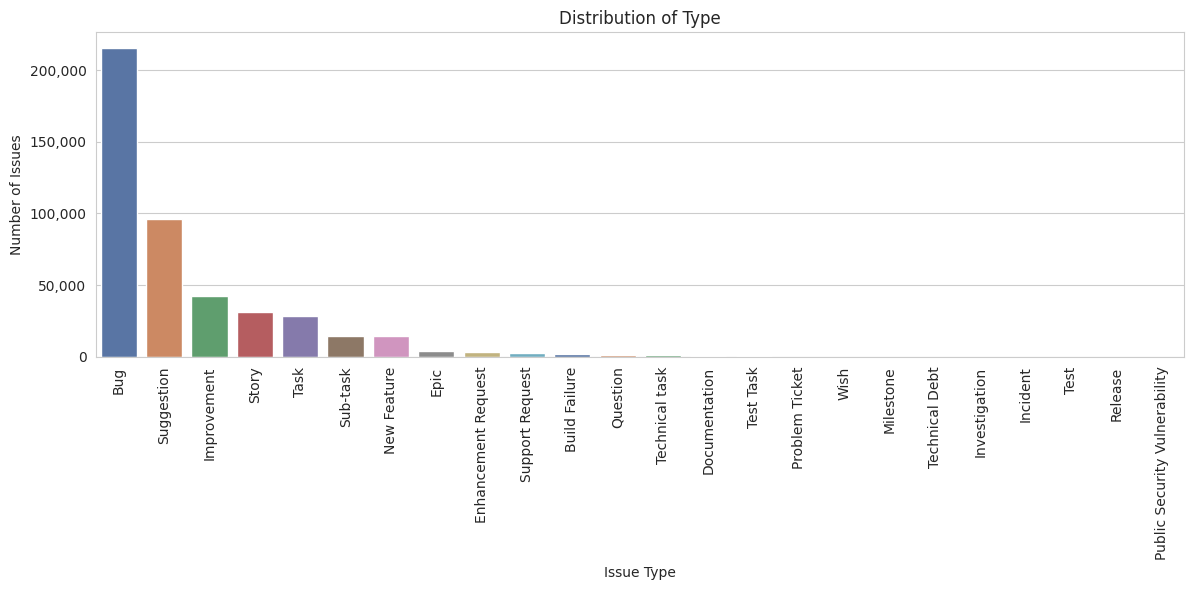

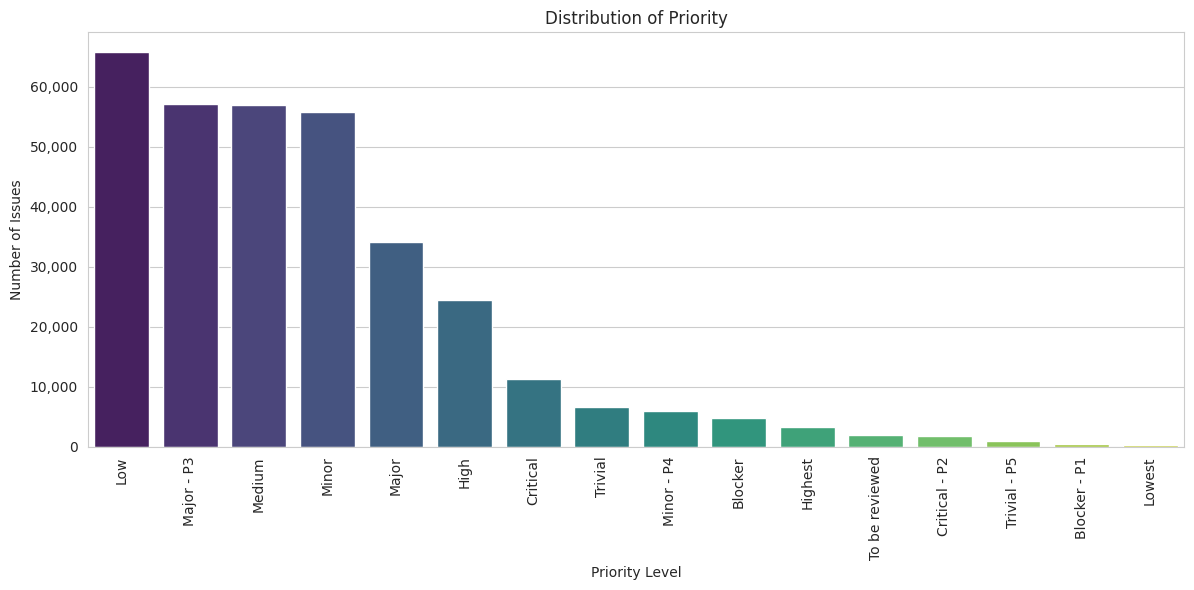

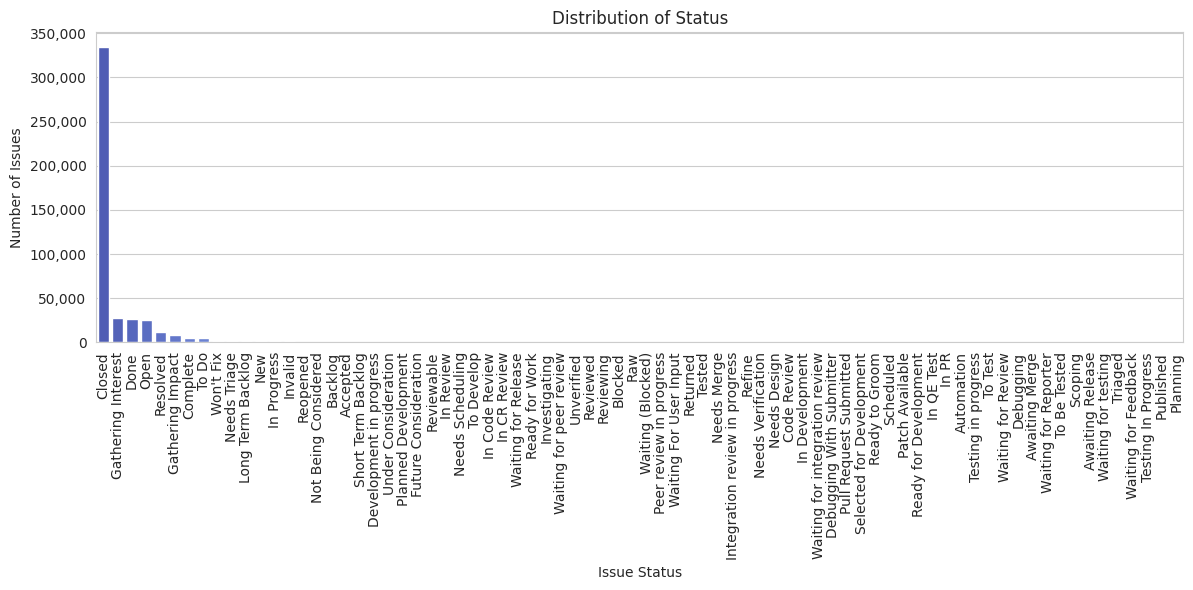

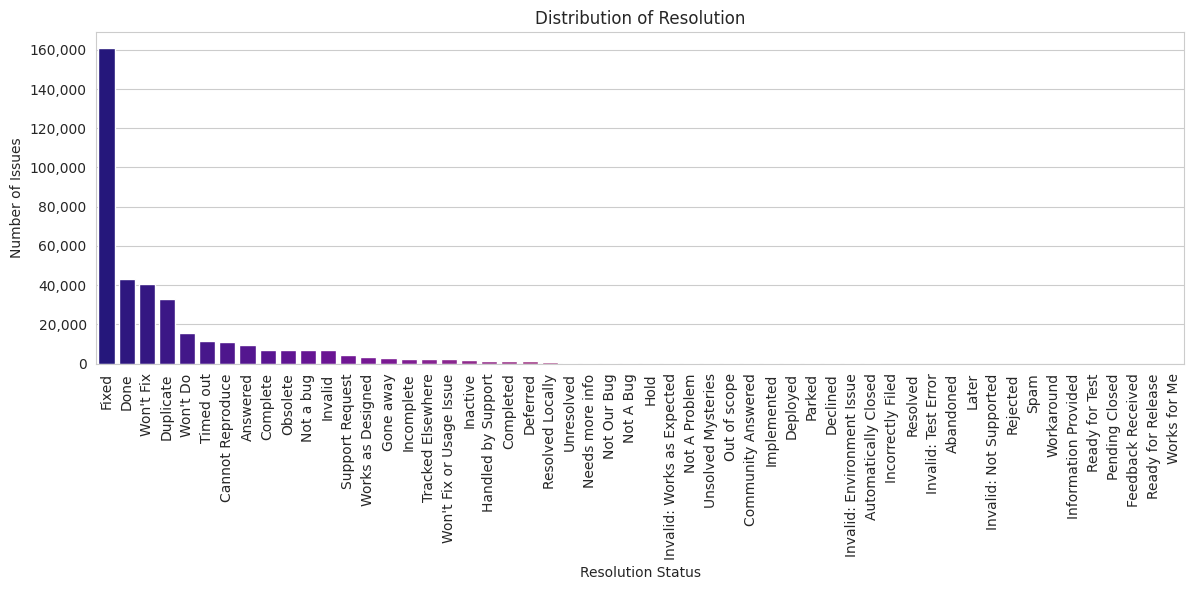

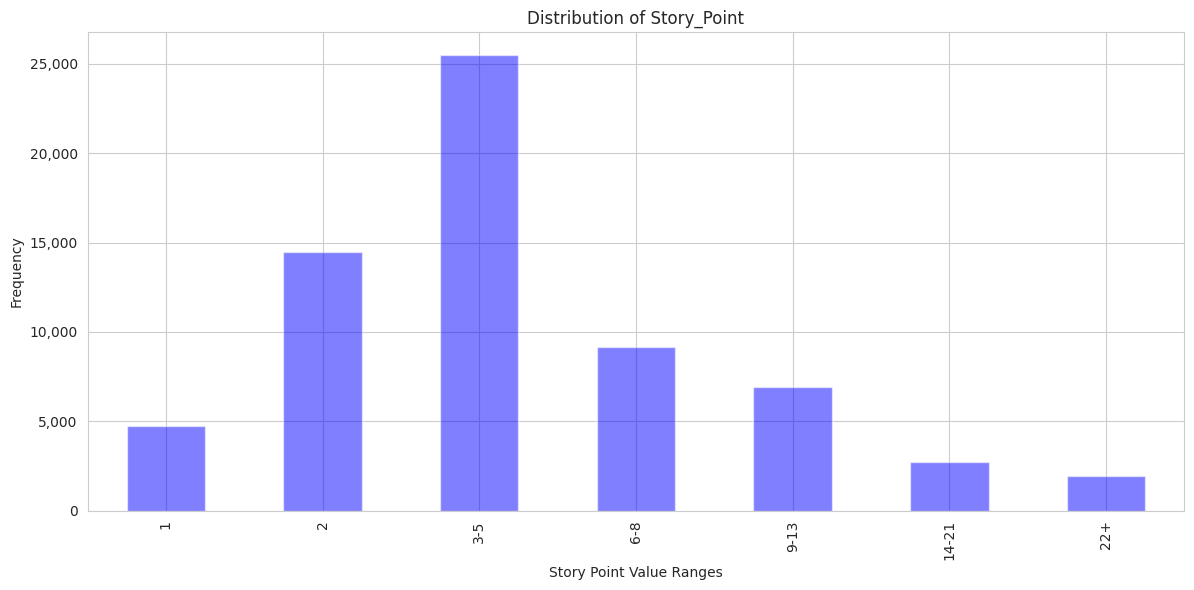

In [12]:
features = [
    {'name': 'Type', 'label': 'Issue Type', 'palette': 'deep'},
    {'name': 'Priority', 'label': 'Priority Level', 'palette': 'viridis'},
    {'name': 'Status', 'label': 'Issue Status', 'palette': 'coolwarm'},
    {'name': 'Resolution', 'label': 'Resolution Status', 'palette': 'plasma'},
    {'name': 'Story_Point', 'label': 'Story Point Value Ranges', 'palette': 'magma'}
]

for feature in features:
    plot_feature_distribution(data=data, feature=feature)

# Data Preprocessing

## Data cleaning

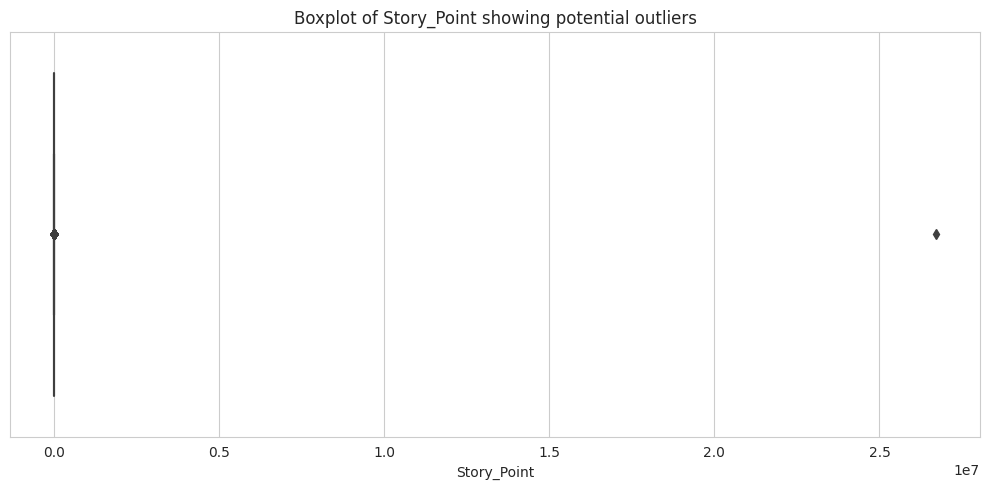

In [13]:
# Plot boxplots Story_Point
plot_boxplot(data=data, feature='Story_Point', title='Boxplot of Story_Point showing potential outliers')

In [14]:
# List of numerical columns to check for outliers
columns_to_check_for_outliers = ['Story_Point']
outliers_stats = identify_outliers(data, columns_to_check_for_outliers)

Story_Point: 1.0961696258663733


In [15]:
columns_to_check_for_outliers = ['Story_Point']
# Apply logarithmic transformation to the columns
data = log_transform_outliers(data, columns_to_check_for_outliers)

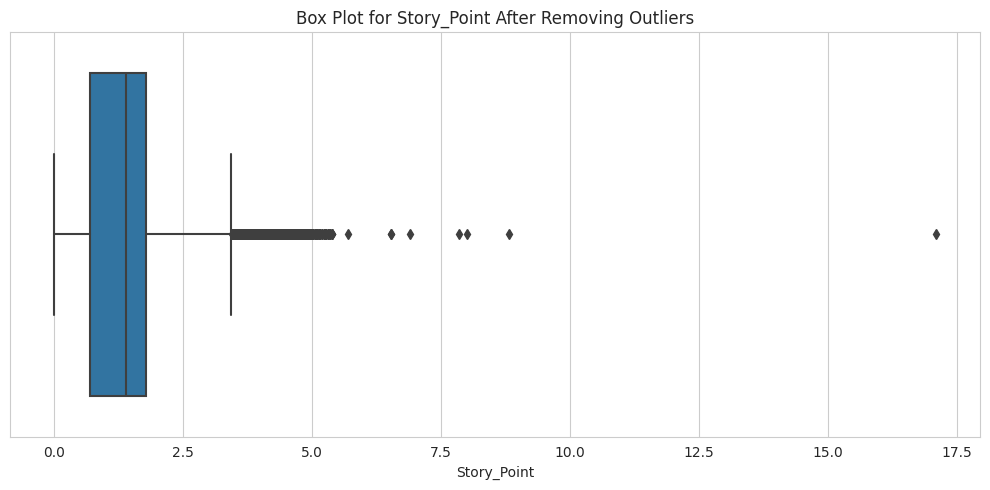

In [16]:
# Visualize the transformed distributions
plot_boxplot(data=data, feature='Story_Point', title='Box Plot for Story_Point After Removing Outliers')

In [17]:
outliers_stats_after_log_transformation = identify_outliers(data, columns_to_check_for_outliers)

Story_Point: 0.2965746608704761


In [18]:
# Check missing values
missing_value_statistics(data)

,Missing Values,Percentage
Pull_Request_URL,457586,99.859023
Timespent,447989,97.764669
Sprint_ID,414757,90.512448
Description_Code,399227,87.123335
Estimation_Date,392805,85.721861
Story_Point,392805,85.721861
Assignee_ID,196401,42.860603
Priority,126659,27.640802
Resolution_Date,105600,23.045095
Resolution,77498,16.912394


In [19]:
# Drop the top two columns with the highest missing values and irrelevant column 'URL'
data.drop(columns=['Timespent', 'Pull_Request_URL', 'URL'], axis=1, inplace=True)

In [20]:
# Convert date columns to datetime format
date_columns = ['Creation_Date', 'Estimation_Date', 'Resolution_Date', 'Last_Updated']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Check the data types again to confirm conversion
data[date_columns].dtypes

Creation_Date      datetime64[ns]
Estimation_Date    datetime64[ns]
Resolution_Date    datetime64[ns]
Last_Updated       datetime64[ns]
dtype: object

In [21]:
columns_to_fill_with_negative = ['Sprint_ID', 'Reporter_ID', 'Creator_ID', 'Jira_ID', 'Assignee_ID']

# Impute missing values for ID columns, with -1
for column in columns_to_fill_with_negative:
    data[column].fillna(-1, inplace=True)

In [22]:
# Impute missing values for 'Priority'
data['Priority'].fillna('Unknown', inplace=True)

# Impute missing values for 'Resolution'
data['Resolution'].fillna('Unknown', inplace=True)

# Impute missing values for 'Estimation_Date' with 'Creation_Date'
data['Estimation_Date'] = data['Estimation_Date'].fillna(data['Creation_Date'])

# Impute missing values for Description columns
data['Description'].fillna('No description', inplace=True)
data['Description_Text'].fillna('No description text', inplace=True)
data['Description_Code'].fillna('No description code', inplace=True)

In [23]:
# Check remaining missing values
missing_value_statistics(data)

,Missing Values,Percentage
Story_Point,392805,85.721861
Resolution_Date,105600,23.045095


In [24]:
# Create a binary column 'Has_Resolution_Date' and drop the original 'Resolution_Date'
data['Has_Resolution_Date'] = data['Resolution_Date'].notna().astype(int)
data.drop(columns='Resolution_Date', inplace=True)

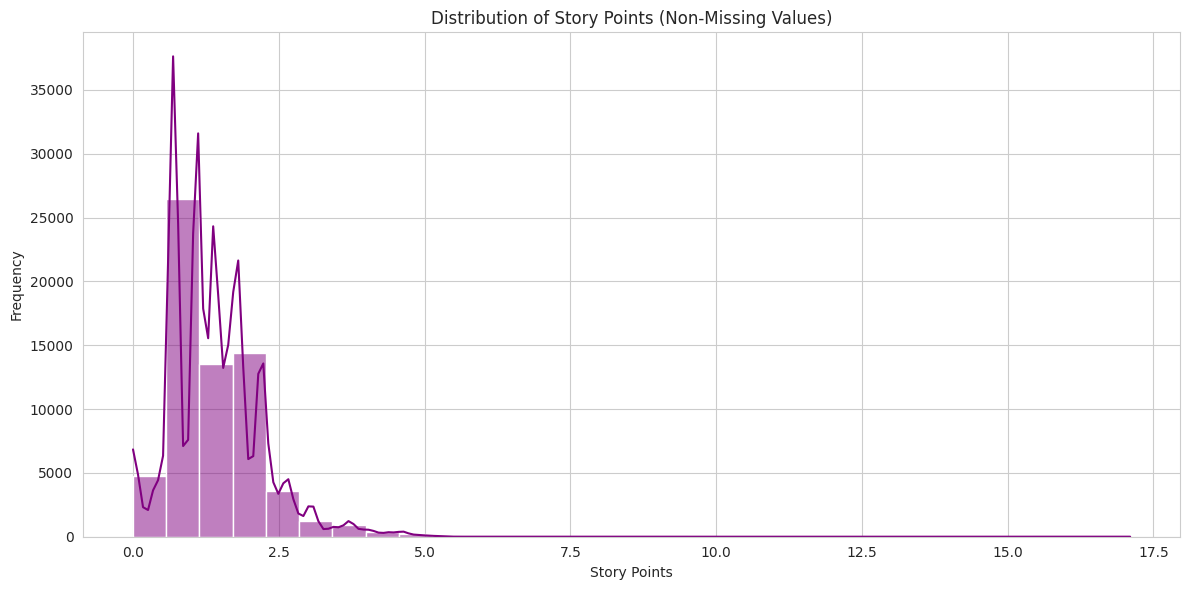

In [25]:
# Plot distribution of story points for non-missing values
plot_non_missing_story_points_distribution(data)

In [26]:
# Impute missing values for 'Story_Point' with its median
data['Story_Point'].fillna(data['Story_Point'].median(), inplace=True)

In [27]:
# Check if there are any remaining missing values
missing_value_statistics(data)

,Missing Values,Percentage


In [28]:
remove_duplicates(data)

Duplicate rows removed: 0


## Feature Engineering

### Feature Extraction

In [29]:
# Extract the time difference between Creation_Date and Estimation_Date
data['Time_To_Estimate_Minutes'] = (data['Estimation_Date'] - data['Creation_Date']).dt.days

In [30]:
# Extract text-based features for 'Title' and 'Description' columns
issue_text_columns = ['Title', 'Description', 'Description_Text', 'Description_Code']
new_columns = []

for column in issue_text_columns:
    # Length of the text
    length_column = f'{column}_Length'
    data[length_column] = data[column].apply(len)
    new_columns.append(length_column)
    # Number of unique words
    unique_words_column = f'{column}_Unique_Words'
    data[unique_words_column] = data[column].apply(lambda x: len(set(x.split())))
    new_columns.append(unique_words_column)

# Check the first few rows to verify the new columns
data[new_columns].head()

,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words,Description_Text_Length,Description_Text_Unique_Words,Description_Code_Length,Description_Code_Unique_Words
0,46,10,130,24,134,24,19,3
1,45,7,1027,68,370,46,639,31
2,57,9,549,66,557,66,19,3
3,22,4,62,2,66,2,19,3
4,69,10,1161,114,1177,114,19,3


### Categorical Encoding

In [31]:
categorical_columns = ['Type', 'Priority', 'Status', 'Resolution']
unique_values_statistics = assess_unique_values(data, categorical_columns)
print(unique_values_statistics)

Type          24
Priority      17
Status        76
Resolution    55
dtype: int64


In [32]:
# Binary encoding for 'Status' and 'Resolution'
binary_encoder = ce.BinaryEncoder(cols=['Status', 'Resolution'])
data = binary_encoder.fit_transform(data)

# One-Hot encoding for 'Type' and 'Priority'
data = pd.get_dummies(data, columns=['Type', 'Priority'], drop_first=True)

In [33]:
data.head()

,ID,Jira_ID,Issue_Key,Title,Description,Description_Text,Description_Code,Status_0,Status_1,Status_2,...,Priority_Lowest,Priority_Major,Priority_Major - P3,Priority_Medium,Priority_Minor,Priority_Minor - P4,Priority_To be reviewed,Priority_Trivial,Priority_Trivial - P5,Priority_Unknown
0,65,77638,XD-3768,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...","""""""The jobs that appear under Executions secti...",No description code,0,0,0,...,False,True,False,False,False,False,False,False,False,False
1,66,77511,XD-3767,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...","""""""Working with Spring-XD version 1.3.2.RELEAS...",""" xd:>admin config admin config info ad...",0,0,0,...,False,False,False,False,False,False,False,True,False,False
2,67,77130,XD-3766,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...","""""""My project 7 node cluster and in that 2 nod...",No description code,0,0,0,...,False,True,False,False,False,False,False,False,False,False
3,68,71950,XD-3765,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...","""""""See https://github.com/spring-projects/spri...",No description code,0,0,0,...,False,False,False,False,True,False,False,False,False,False
4,69,71805,XD-3764,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...","""""""I'm trying to run a Job on SpringXD and the...",No description code,0,0,0,...,False,True,False,False,False,False,False,False,False,False


### Feature Scaling

In [34]:
features_to_scale = [
    'Title_Length', 'Title_Unique_Words',
    'Description_Length', 'Description_Unique_Words',
    'Description_Text_Length', 'Description_Text_Unique_Words',
    'Description_Code_Length', 'Description_Code_Unique_Words'
]

# Apply standardization
scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [35]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include=[float, int])

In [36]:
# save processed data for use in Model development
save_processed_data(numeric_data)

## Correlation Analysis with Pearson correlation coefficient

In [37]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Compute the correlation with 'Story_Point'
correlations = numeric_data.corr()['Story_Point'].drop('Story_Point')

# Display the top 10 features with the highest absolute correlation
top_correlations = correlations.abs().sort_values(ascending=False).head(10)
print(top_correlations)

Story_Point_Changed_After_Estimation    0.136694
In_Progress_Minutes                     0.078277
Sprint_ID                               0.056332
Status_4                                0.050915
Time_To_Estimate_Minutes                0.050140
Title_Changed_After_Estimation          0.045239
Total_Effort_Minutes                    0.044463
Project_ID                              0.035632
Resolution_5                            0.034962
ID                                      0.021872
Name: Story_Point, dtype: float64


### Plot correlation matrix

[2023-08-30 08:06:26,487] 876 matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f904fabf8b0>


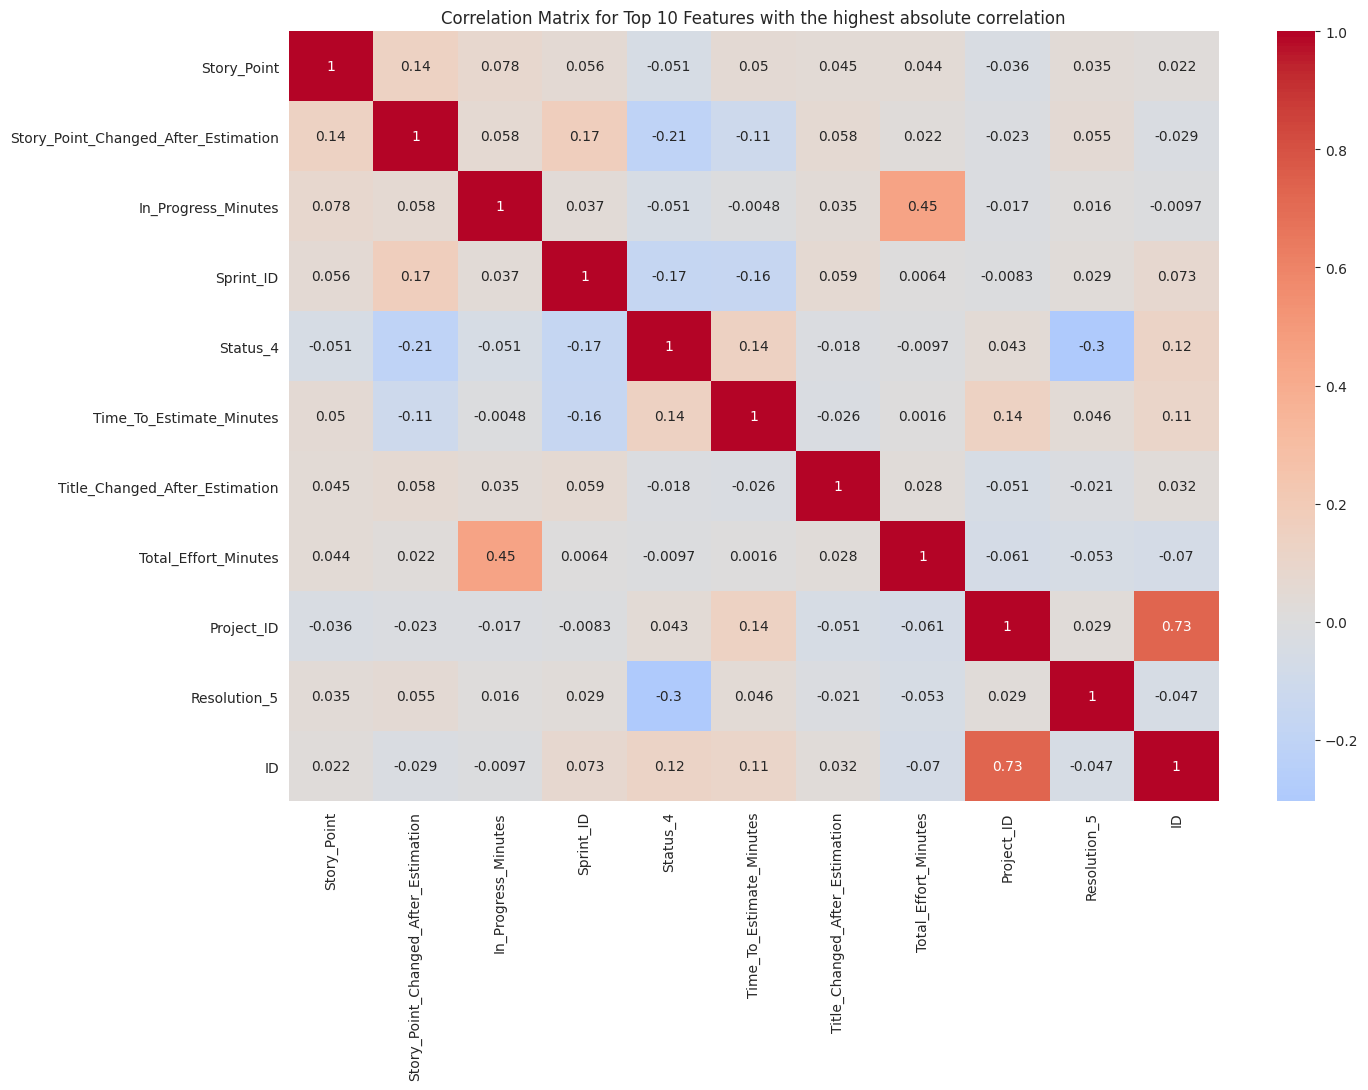

In [38]:
top_features = top_correlations.index.insert(0, 'Story_Point')

# Compute the correlation matrix for the top features
correlation_matrix = data[top_features].corr()

# Plot the heatmap
plot_correlation_matrix(correlation_matrix, 'Correlation Matrix for Top 10 Features with the highest absolute correlation')

## Feature Selection with Fuzzy GRA

### Fuzzification

In [39]:
fuzzy_data = normalize_data(numeric_data)
fuzzy_data.head()

,ID,Jira_ID,Status_0,Status_1,Status_2,Status_3,Status_4,Status_5,Status_6,Resolution_0,...,Has_Resolution_Date,Time_To_Estimate_Minutes,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words,Description_Text_Length,Description_Text_Unique_Words,Description_Code_Length,Description_Code_Unique_Words
0,0.000000,0.005076,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.160448,0.204545,0.000091,0.002291,0.000092,0.002291,0.000023,0.000281
1,0.000002,0.005066,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.156716,0.136364,0.000734,0.006675,0.000261,0.004483,0.000973,0.004212
2,0.000004,0.005037,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.201493,0.181818,0.000391,0.006475,0.000395,0.006475,0.000023,0.000281
3,0.000006,0.004649,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.070896,0.068182,0.000042,0.000100,0.000043,0.000100,0.000023,0.000281
4,0.000008,0.004638,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.246269,0.204545,0.000830,0.011257,0.000839,0.011257,0.000023,0.000281


### Calculate Grey Relational Coefficient

In [40]:
reference_sequence = fuzzy_data['Story_Point'].mean()
coefficients = fuzzy_data.apply(lambda x: grey_relational_coefficient(x, reference_sequence))
# Drop the target column as we don't need its relational coefficient with itself
coefficients = coefficients.drop(columns=['Story_Point'])

In [41]:
# Calculate the absolute difference between each feature and the target (Story_Point)
deltas = abs(fuzzy_data.drop(columns='Story_Point') - fuzzy_data['Story_Point'].values.reshape(-1, 1))

# Calculate delta_min and delta_max
delta_min = deltas.min().min()
delta_max = deltas.max().max()

# Calculate Grey Relational Coefficients (GRC) using the formula
rho = 0.5
GRC = (delta_min + rho * delta_max) / (deltas + rho * delta_max)

GRC.head()

,ID,Jira_ID,Status_0,Status_1,Status_2,Status_3,Status_4,Status_5,Status_6,Resolution_0,...,Has_Resolution_Date,Time_To_Estimate_Minutes,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words,Description_Text_Length,Description_Text_Unique_Words,Description_Code_Length,Description_Code_Unique_Words
0,0.925012,0.933780,0.925012,0.925012,0.925012,0.925012,0.925012,0.925012,0.342591,0.925012,...,0.925012,0.925012,0.806563,0.752999,0.925168,0.928950,0.925169,0.928950,0.925051,0.925493
1,0.925015,0.933763,0.925012,0.925012,0.925012,0.925012,0.925012,0.925012,0.342591,0.925012,...,0.925012,0.925012,0.811448,0.839165,0.926269,0.936577,0.925458,0.932748,0.926681,0.932277
2,0.780982,0.787171,0.780978,0.780978,0.780978,0.780978,0.780978,0.780978,0.367707,0.780978,...,0.780978,0.780978,0.890838,0.923199,0.781455,0.788957,0.781460,0.788957,0.781006,0.781320
3,0.795567,0.801488,0.795559,0.795559,0.795559,0.795559,0.795559,0.364561,0.795559,0.795559,...,0.364561,0.364561,0.896711,0.892368,0.795613,0.795686,0.795614,0.795686,0.795589,0.795915
4,0.826761,0.833139,0.826750,0.826750,0.826750,0.826750,0.826750,0.826750,0.358366,0.826750,...,0.826750,0.358366,0.779434,0.833656,0.827886,0.842431,0.827899,0.842431,0.826781,0.827134


### Compute Grey Relational Grade

In [43]:
# Calculate Grey Relational Grade (GRG) for each feature
GRG = GRC.mean()

# Sorting the features based on GRG
GRG_sorted = GRG.sort_values(ascending=False)

### Feature Ranking

In [45]:
ranked_features = GRG_sorted
ranked_features

Jira_ID                                 0.879902
Description_Unique_Words                0.869595
Description_Text_Unique_Words           0.868676
Total_Effort_Minutes                    0.863733
Description_Code_Unique_Words           0.862883
Description_Length                      0.862092
In_Progress_Minutes                     0.861999
Description_Code_Length                 0.861847
Description_Text_Length                 0.861768
Resolution_Time_Minutes                 0.861016
Status_0                                0.860520
Story_Point_Changed_After_Estimation    0.851382
Status_1                                0.849885
Title_Unique_Words                      0.843925
Status_3                                0.840669
Sprint_ID                               0.833646
Resolution_1                            0.828054
Status_2                                0.813083
Resolution_0                            0.806339
Title_Length                            0.800852
Title_Changed_After_

### Visualise the feature importance

[2023-08-30 01:34:58,145] 876 matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f7dce9e5b70>


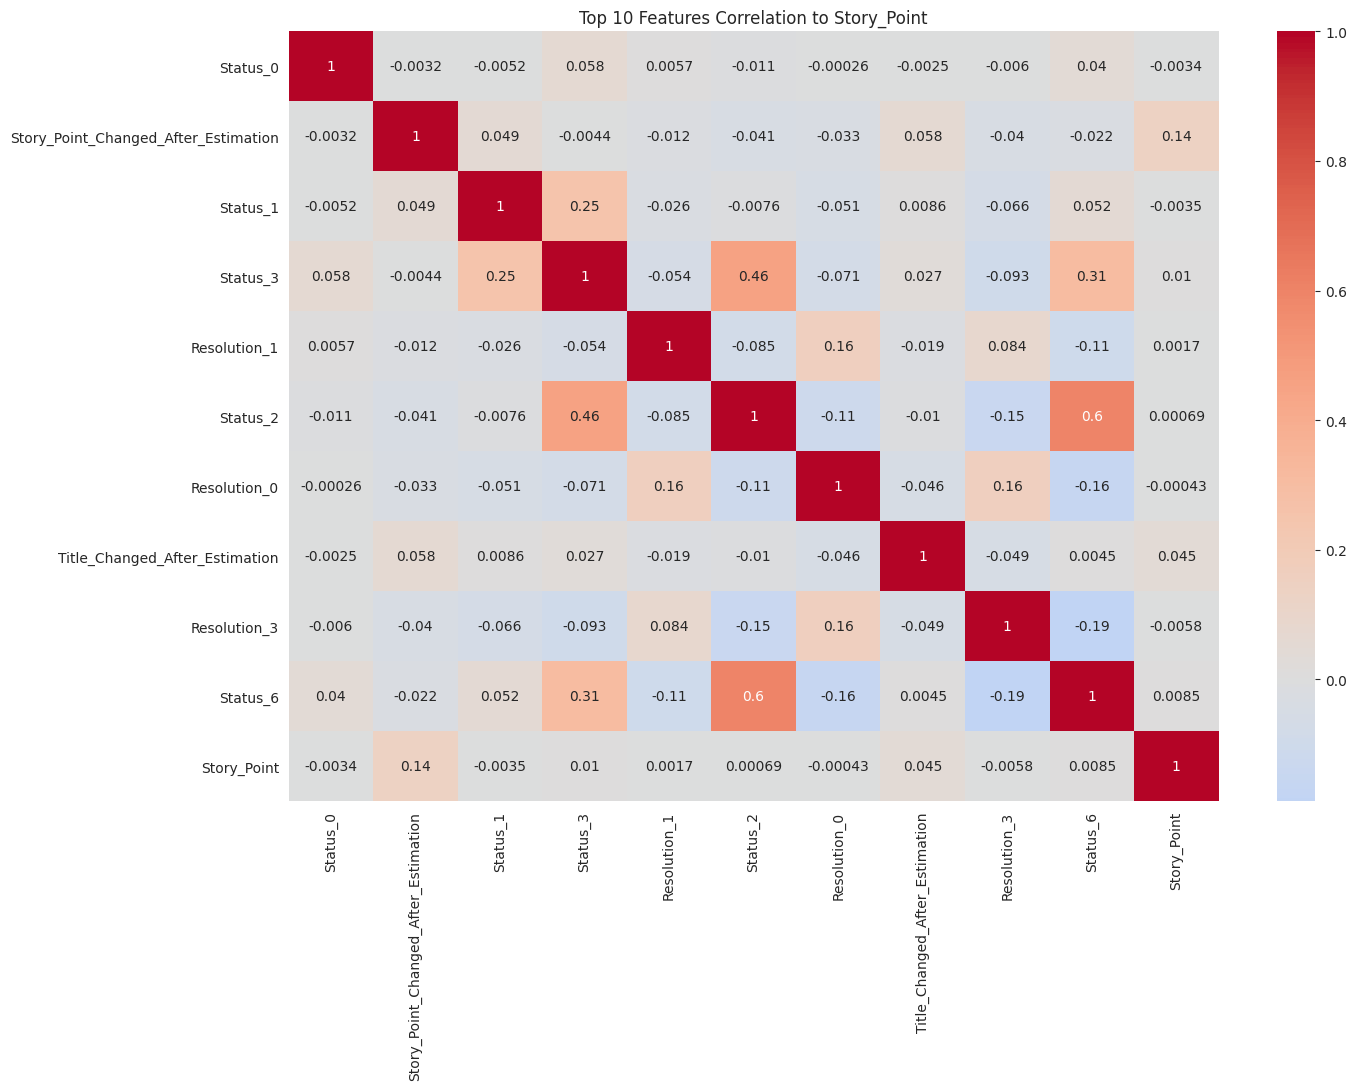

In [304]:
top_features_with_highest_ranking_with_sp = ranked_features.index[:10]

# Create a smaller correlation matrix with only the top features including 'Story_Point'
fgra_correlation_matrix = data[top_features_with_highest_ranking_with_sp].join(data['Story_Point']).corr()

# Plot the heatmap
plot_correlation_matrix(fgra_correlation_matrix, 'Top 10 Features Correlation to Story_Point')

# Model Development

## Data Splitting

In [306]:
# # Features and target variable
# # X = numeric_data.drop(columns=['Story_Point'])
# top_correlations = correlations.abs().sort_values(ascending=False).head(3)
# X = numeric_data[top_correlations.index]
# y = numeric_data['Story_Point']
# 
# # Splitting the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [307]:
# # selected_features = ranked_features.index[:25]  # selecting top 10 features
# selected_features = GRG_sorted.index[:25]
# X_selected = numeric_data[selected_features]
# y_selected = numeric_data['Story_Point']
# 
# # Splitting the data with selected features
# X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.25, random_state=42)

## Train Models without FGRA Features

In [ ]:
# Features and target variable
X = numeric_data.drop(columns=['Story_Point'])
X = numeric_data[top_correlations.index]
y = numeric_data['Story_Point']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Linear Regression (Baseline Model) Metrics:
MSE: 0.08902633612557345
RMSE: 0.2983728139854123
MAE: 0.09424778514171857
R2: 0.025850107855363236


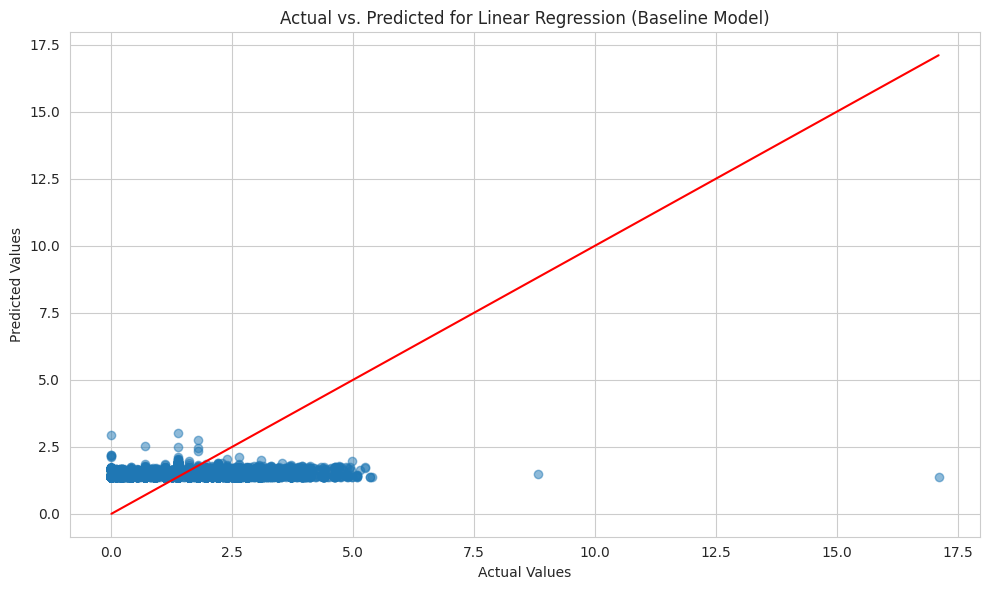

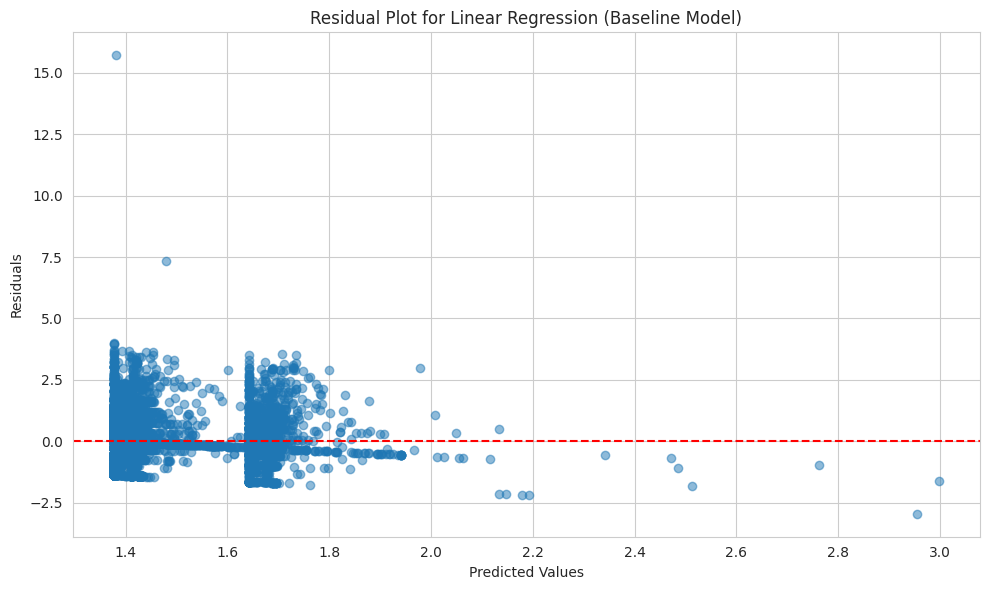

Random Forest Regression Metrics:
MSE: 0.08556387296869977
RMSE: 0.2925130304254834
MAE: 0.09630031246535829
R2: 0.06373730233751795


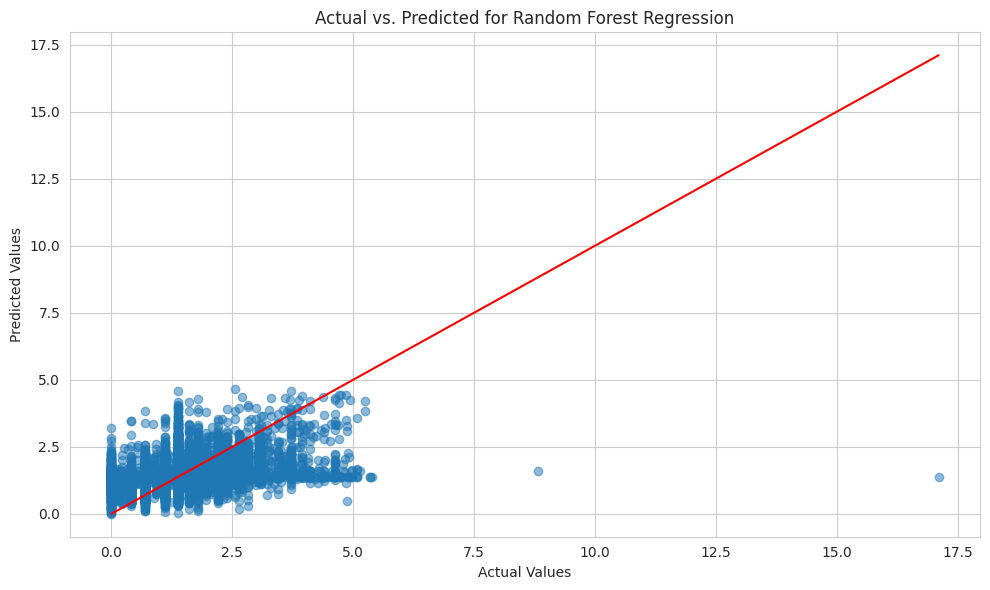

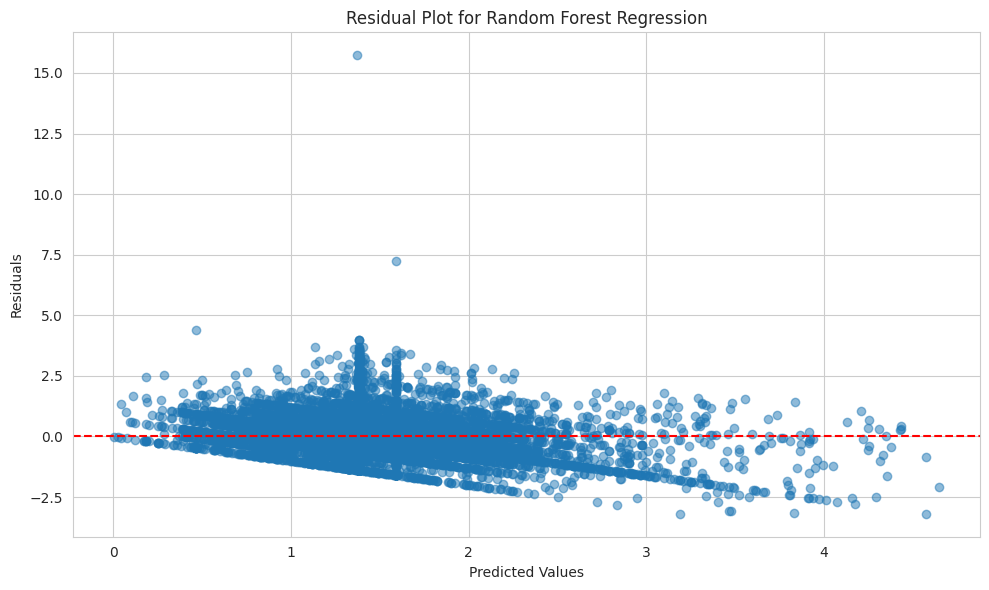

Gradient Boosting Regression Metrics:
MSE: 0.07703014802249751
RMSE: 0.27754305615975605
MAE: 0.09085583489809577
R2: 0.15711559462407343


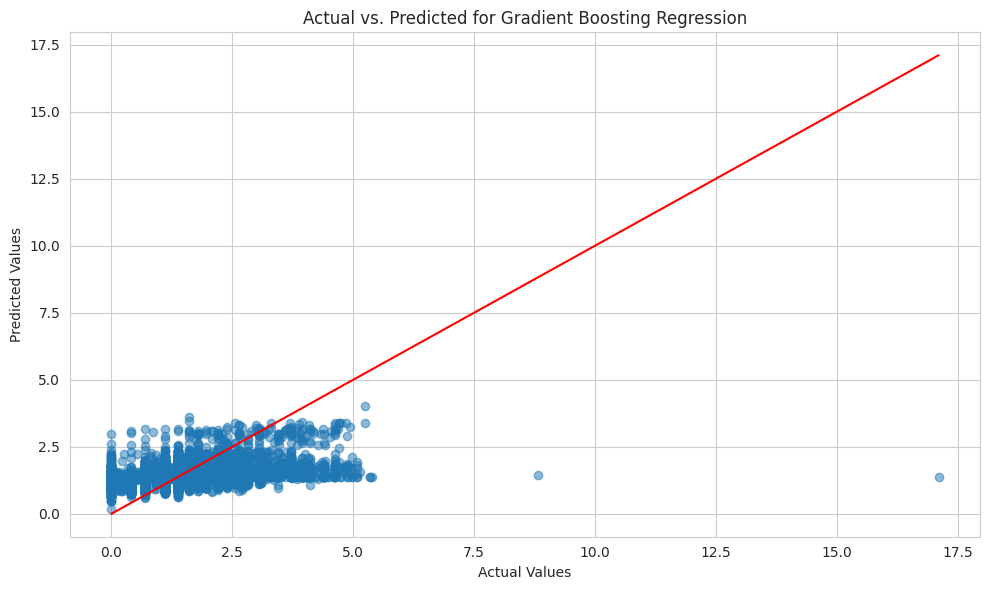

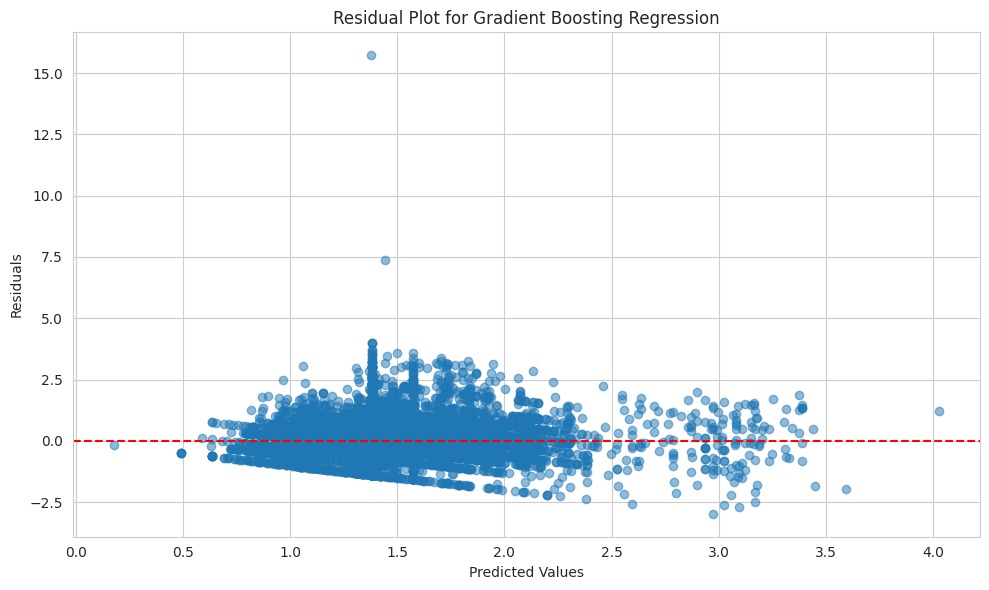

Epoch 1/100
10740/10740 [==============================] - 74s 5ms/step - loss: 585176.3125 - val_loss: 0.4479
Epoch 2/100
10740/10740 [==============================] - 38s 4ms/step - loss: 9.2462 - val_loss: 0.0918
Epoch 3/100
10740/10740 [==============================] - 47s 4ms/step - loss: 42.6681 - val_loss: 0.0912
Epoch 4/100
10740/10740 [==============================] - 29s 3ms/step - loss: 1.5572 - val_loss: 0.0912
Epoch 5/100
10740/10740 [==============================] - 28s 3ms/step - loss: 0.0900 - val_loss: 0.0911
Epoch 6/100
10740/10740 [==============================] - 32s 3ms/step - loss: 0.2209 - val_loss: 0.0913
Epoch 7/100
10740/10740 [==============================] - 31s 3ms/step - loss: 0.1580 - val_loss: 0.0911
Epoch 8/100
10740/10740 [==============================] - 27s 2ms/step - loss: 0.0934 - val_loss: 0.0913
Epoch 9/100
10740/10740 [==============================] - 28s 3ms/step - loss: 0.1020 - val_loss: 0.0912
Epoch 10/100
10740/10740 [==============

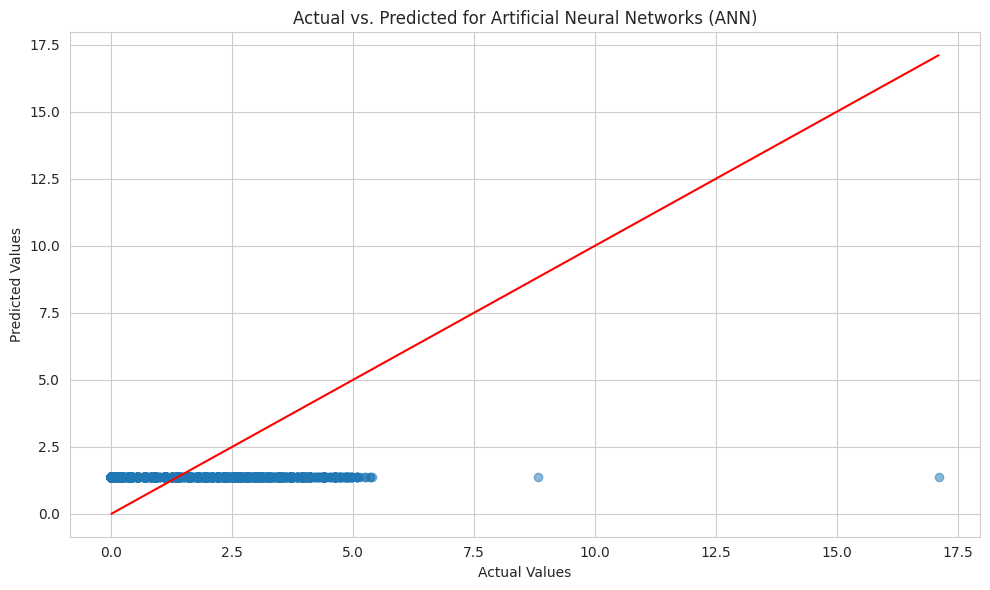

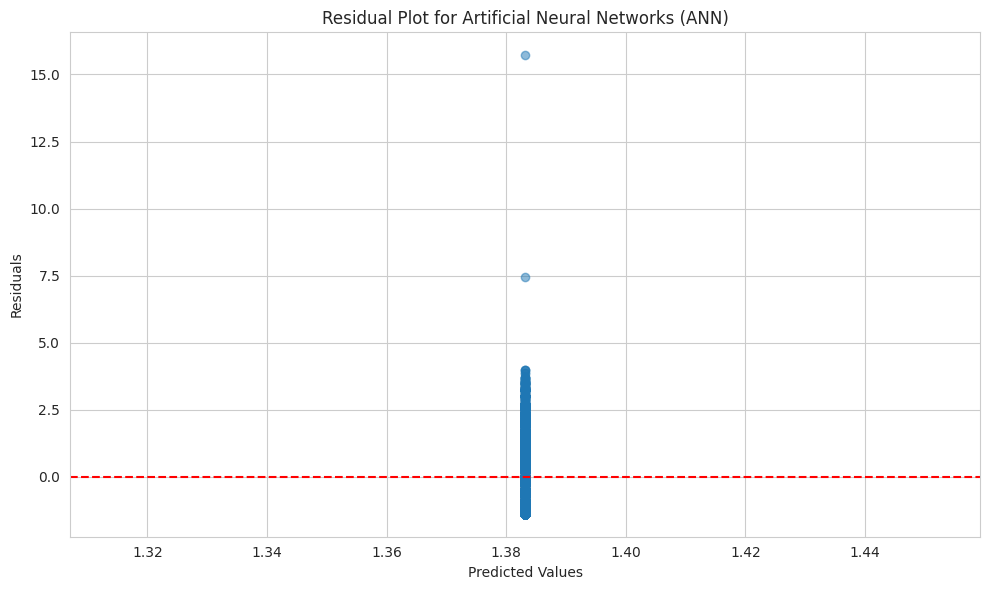

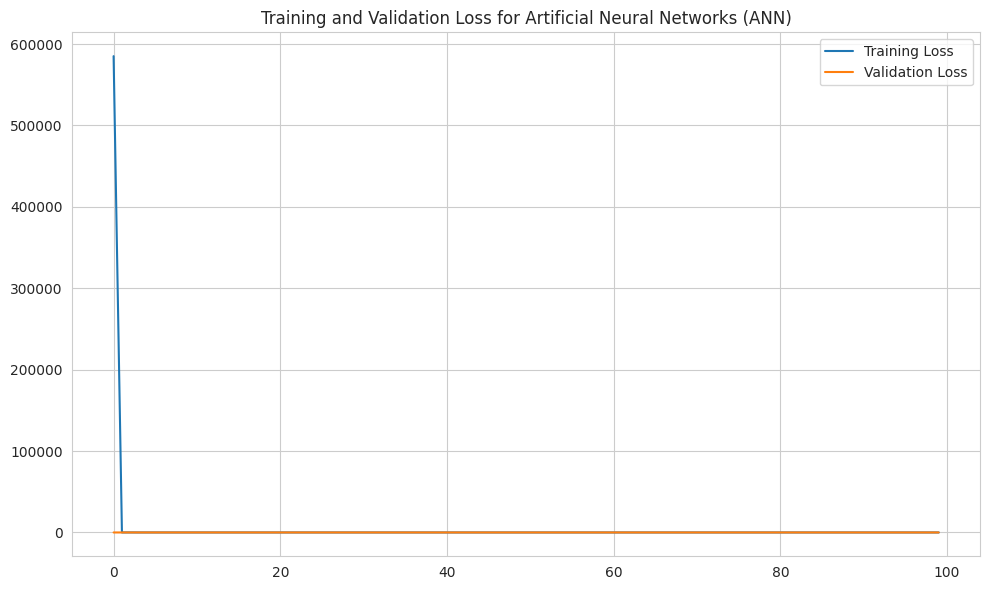

CPU times: user 1h 3min 21s, sys: 15min 24s, total: 1h 18min 46s
Wall time: 49min 3s


In [308]:
%%time
models_without_fgra = [
    ('Linear Regression (Baseline Model)', LinearRegression()),
    ('Random Forest Regression', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting Regression', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('Artificial Neural Networks (ANN)', None),
]
trained_models_without_fgra = train_and_evaluate_models(models_without_fgra, X_train, y_train, X_test, y_test)

## Train Models with FGRA Features

In [ ]:
selected_features = GRG_sorted.index[:20] # selecting top 20 features
X_selected = numeric_data[selected_features]
y_selected = numeric_data['Story_Point']

# Splitting the data with selected features
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.25, random_state=42)

Random Forest (with FGRA Features) Metrics:
MSE: 0.055228919129348394
RMSE: 0.23500833842514693
MAE: 0.07765983158072488
R2: 0.3956704504020938


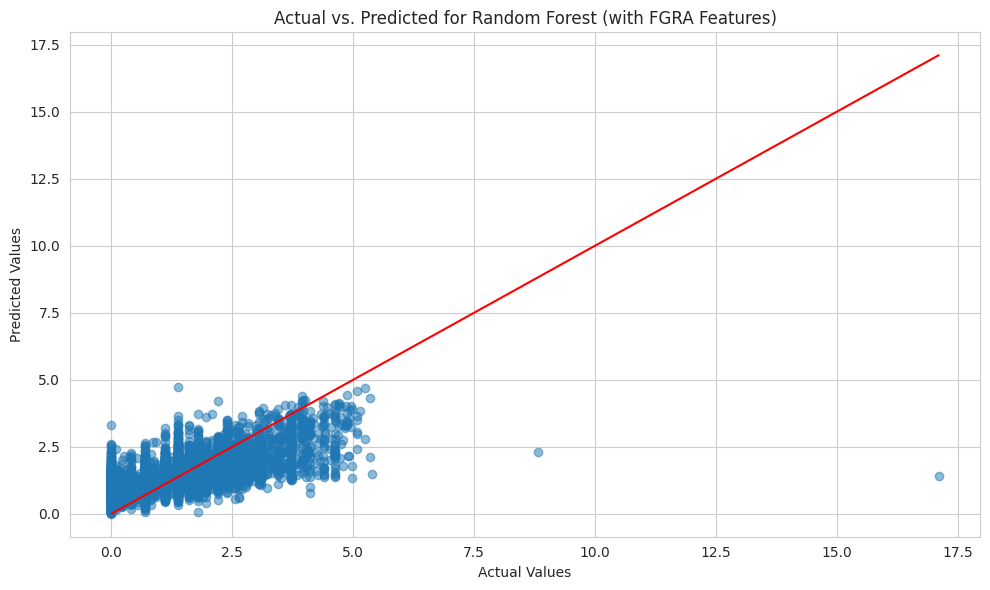

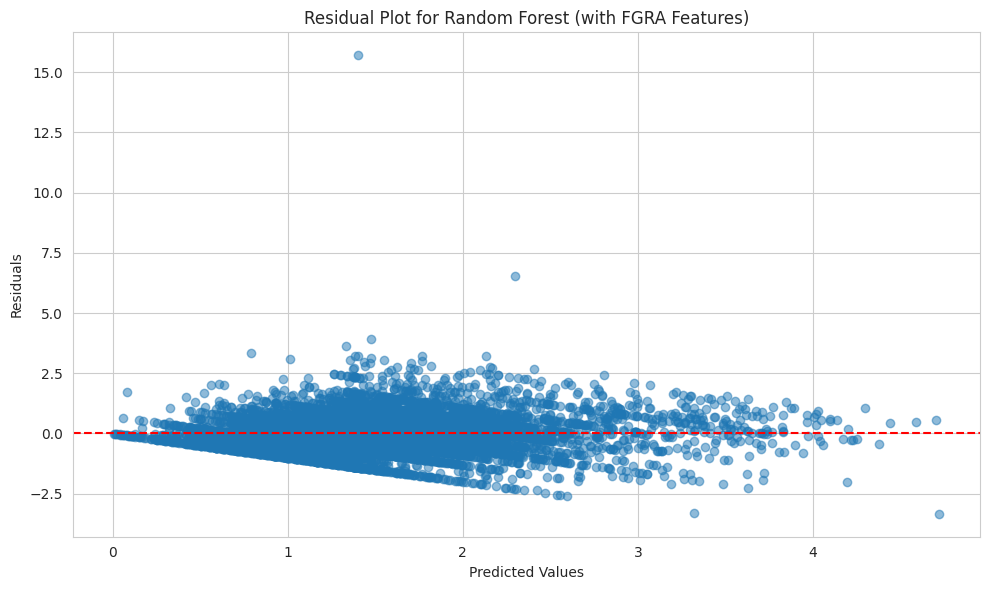

Gradient Boosting (with FGRA Features) Metrics:
MSE: 0.06286673404672637
RMSE: 0.2507323952877377
MAE: 0.08465969061312431
R2: 0.31209544437815007


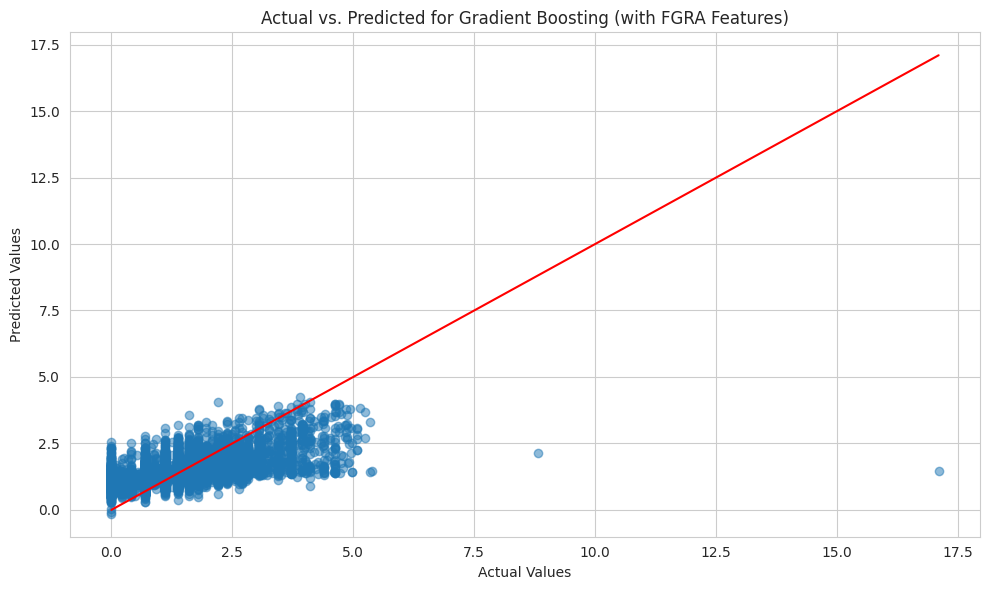

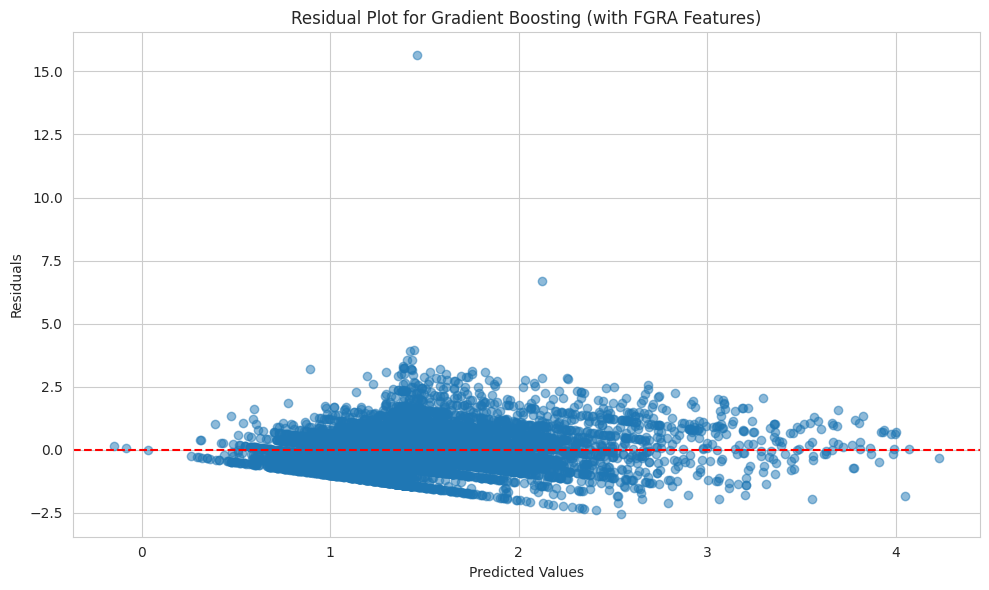

Epoch 1/100
10740/10740 [==============================] - 22s 2ms/step - loss: 71588000.0000 - val_loss: 1.8920
Epoch 2/100
10740/10740 [==============================] - 19s 2ms/step - loss: 483558.8438 - val_loss: 1.4315
Epoch 3/100
10740/10740 [==============================] - 21s 2ms/step - loss: 1174.6638 - val_loss: 0.1061
Epoch 4/100
10740/10740 [==============================] - 22s 2ms/step - loss: 49.4673 - val_loss: 0.0914
Epoch 5/100
10740/10740 [==============================] - 19s 2ms/step - loss: 4.1764 - val_loss: 0.0914
Epoch 6/100
10740/10740 [==============================] - 23s 2ms/step - loss: 5941.7690 - val_loss: 0.0921
Epoch 7/100
10740/10740 [==============================] - 20s 2ms/step - loss: 48169.5586 - val_loss: 0.0923
Epoch 8/100
10740/10740 [==============================] - 22s 2ms/step - loss: 25.7631 - val_loss: 0.0914
Epoch 9/100
10740/10740 [==============================] - 22s 2ms/step - loss: 0.0865 - val_loss: 0.0914
Epoch 10/100
10740/107

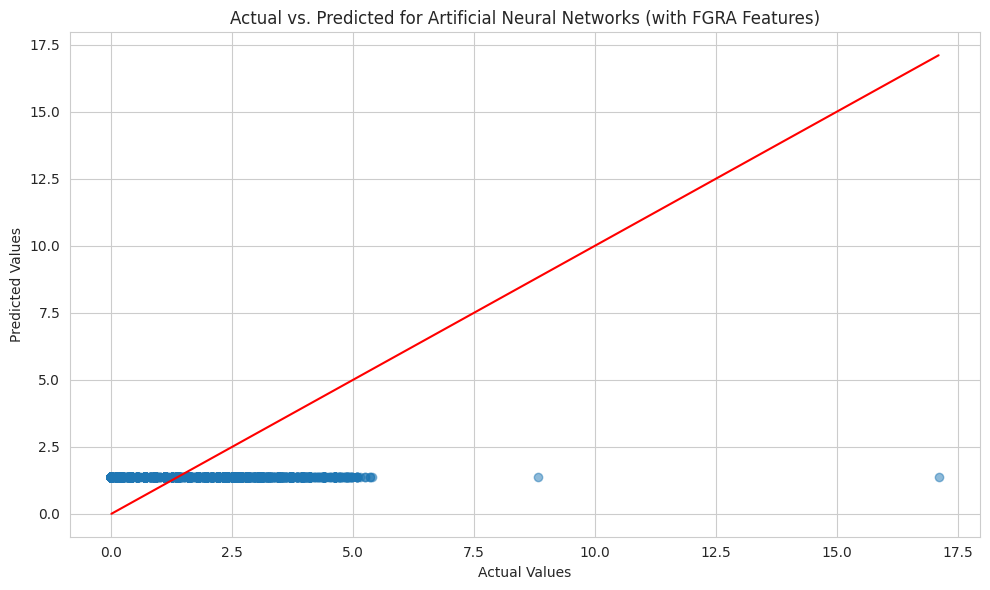

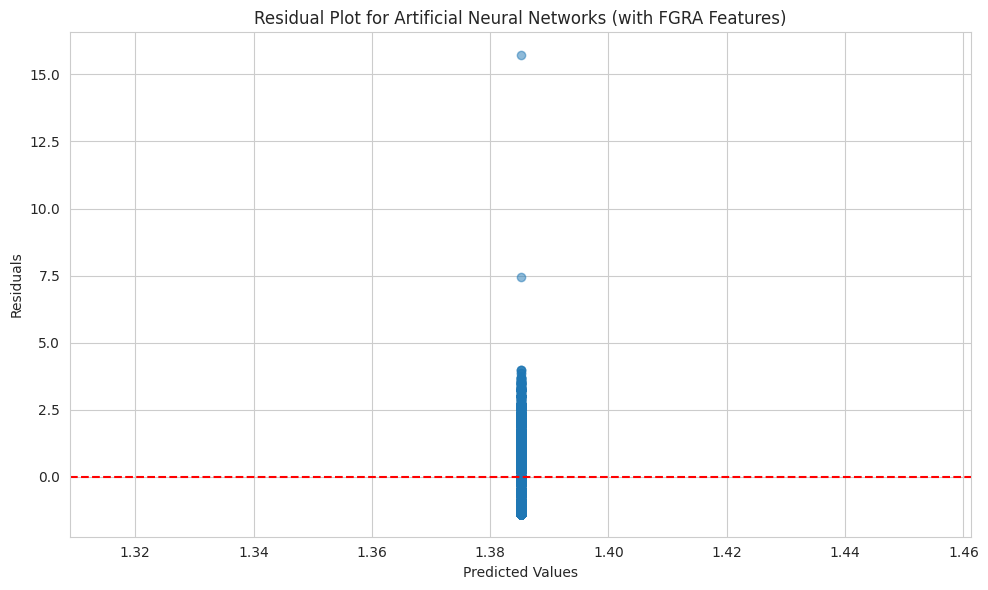

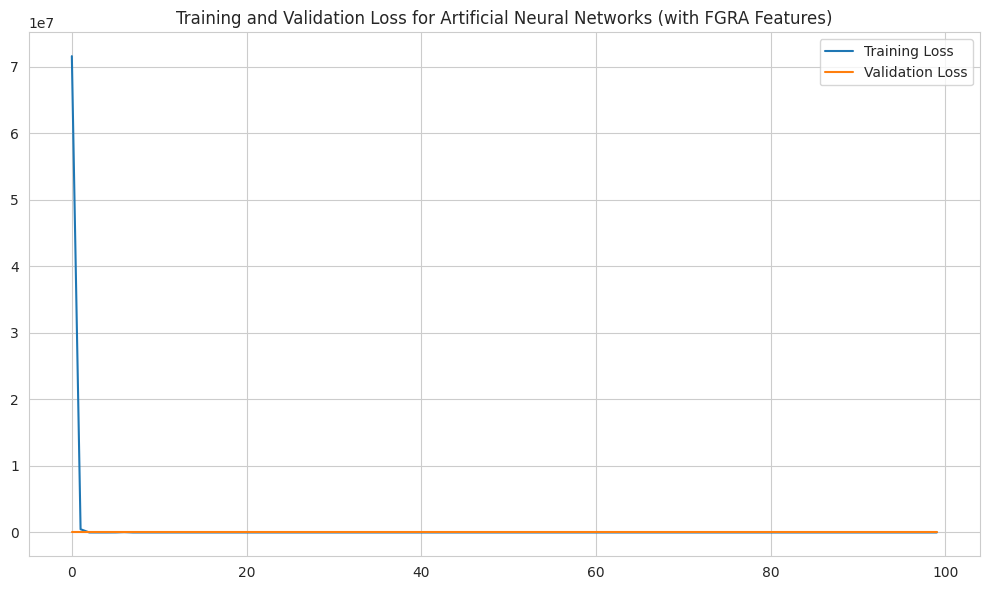

CPU times: user 1h 12min 5s, sys: 16min 23s, total: 1h 28min 28s
Wall time: 57min 15s


In [309]:
%%time
models_with_fgra = [
    ('Random Forest (with FGRA Features)', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting (with FGRA Features)', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('Artificial Neural Networks (with FGRA Features)', None),
]
predictions_with_fgra = train_and_evaluate_models(models_with_fgra, X_train_selected, y_train_selected, X_test_selected, y_test_selected)

In [310]:
selected_features = ranked_features.index[:25]  # selecting top 10 features
# selected_features = GRG_sorted.index[:25]
X_selected = numeric_data[selected_features]
y_selected = numeric_data['Story_Point']

# Splitting the data with selected features
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.25, random_state=42)

Random Forest (with FGRA Features) Metrics:
MSE: 0.06293799229133669
RMSE: 0.25087445523874424
MAE: 0.0908619192479136
R2: 0.311315717677911


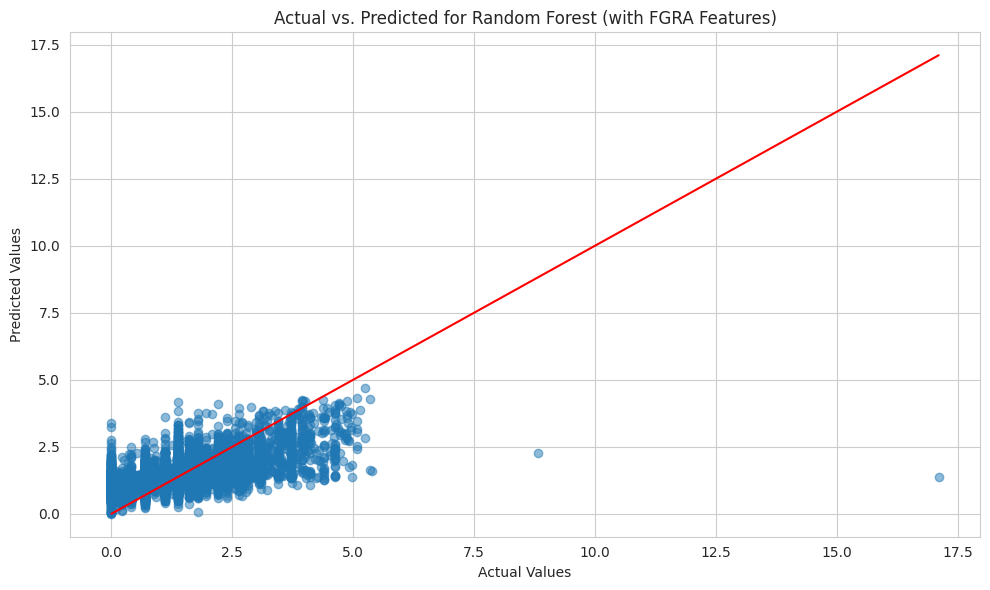

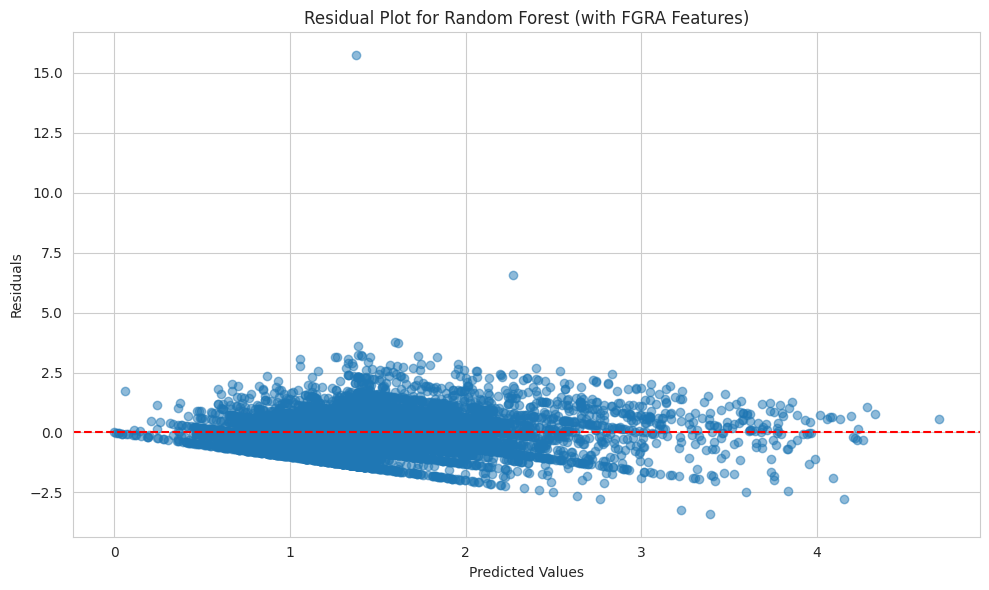

Gradient Boosting (with FGRA Features) Metrics:
MSE: 0.06813442488918968
RMSE: 0.26102571691155196
MAE: 0.09254203690602009
R2: 0.2544549675331992


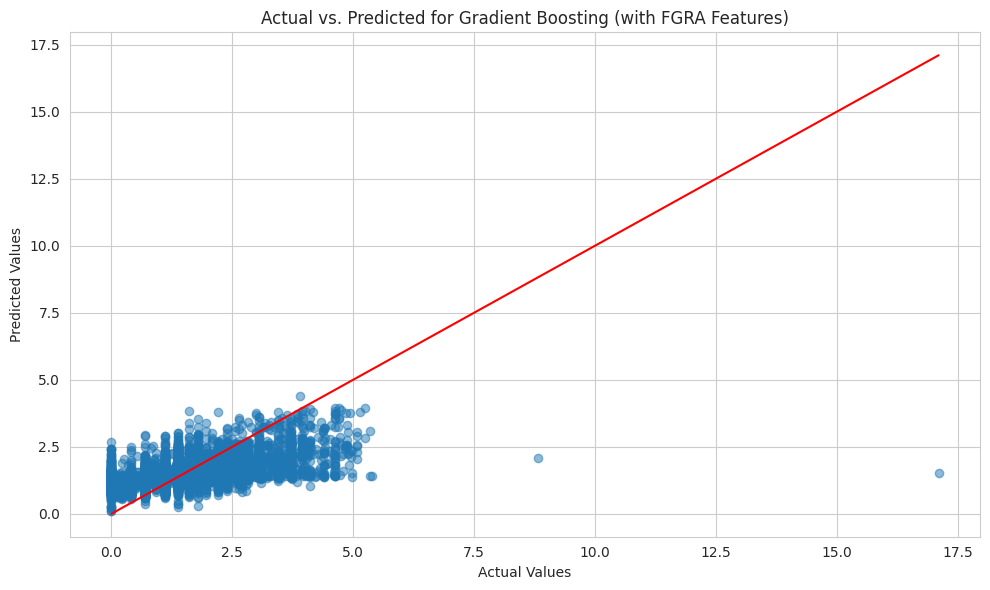

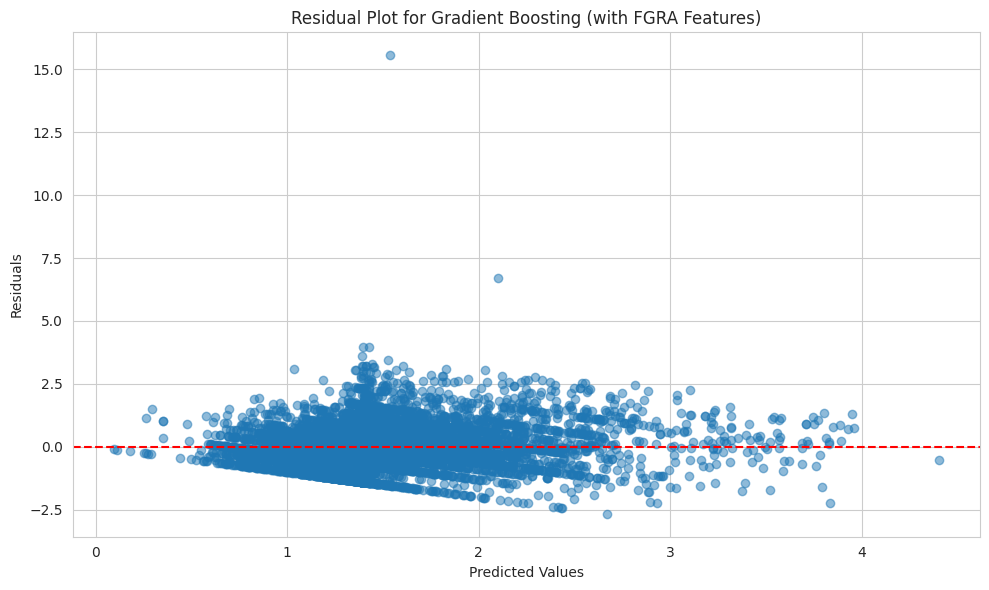

Epoch 1/100
10740/10740 [==============================] - 27s 2ms/step - loss: 171384720.0000 - val_loss: 2.0948
Epoch 2/100
10740/10740 [==============================] - 22s 2ms/step - loss: 63127.7578 - val_loss: 1.1598
Epoch 3/100
10740/10740 [==============================] - 22s 2ms/step - loss: 288.3192 - val_loss: 0.0919
Epoch 4/100
10740/10740 [==============================] - 23s 2ms/step - loss: 497.3104 - val_loss: 0.0916
Epoch 5/100
10740/10740 [==============================] - 23s 2ms/step - loss: 1.3429 - val_loss: 0.0914
Epoch 6/100
10740/10740 [==============================] - 22s 2ms/step - loss: 12.3438 - val_loss: 0.0914
Epoch 7/100
10740/10740 [==============================] - 22s 2ms/step - loss: 339.5361 - val_loss: 0.0914
Epoch 8/100
10740/10740 [==============================] - 23s 2ms/step - loss: 11.2929 - val_loss: 0.0914
Epoch 9/100
10740/10740 [==============================] - 24s 2ms/step - loss: 11.0801 - val_loss: 0.0915
Epoch 10/100
10740/10740 

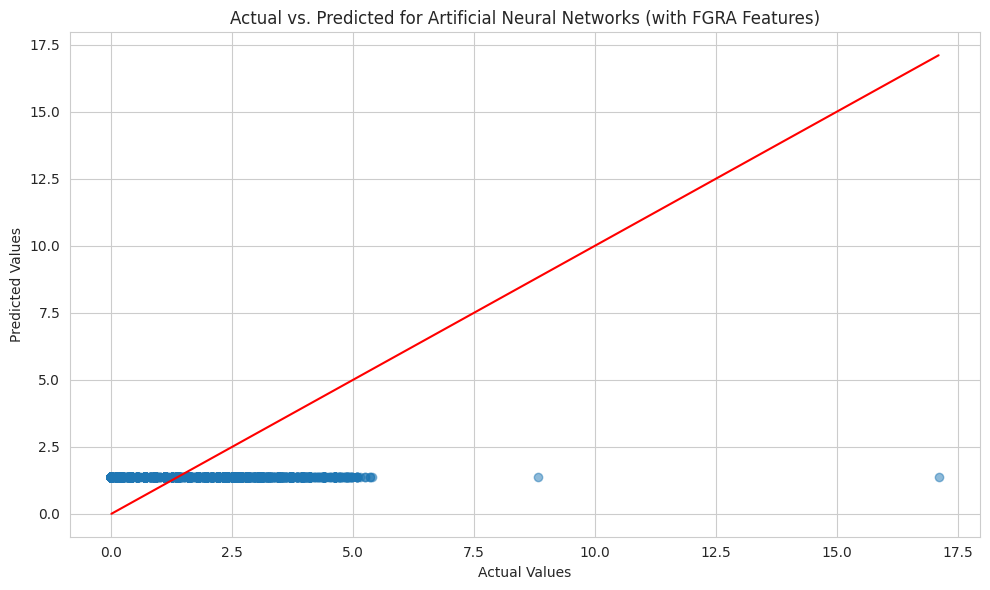

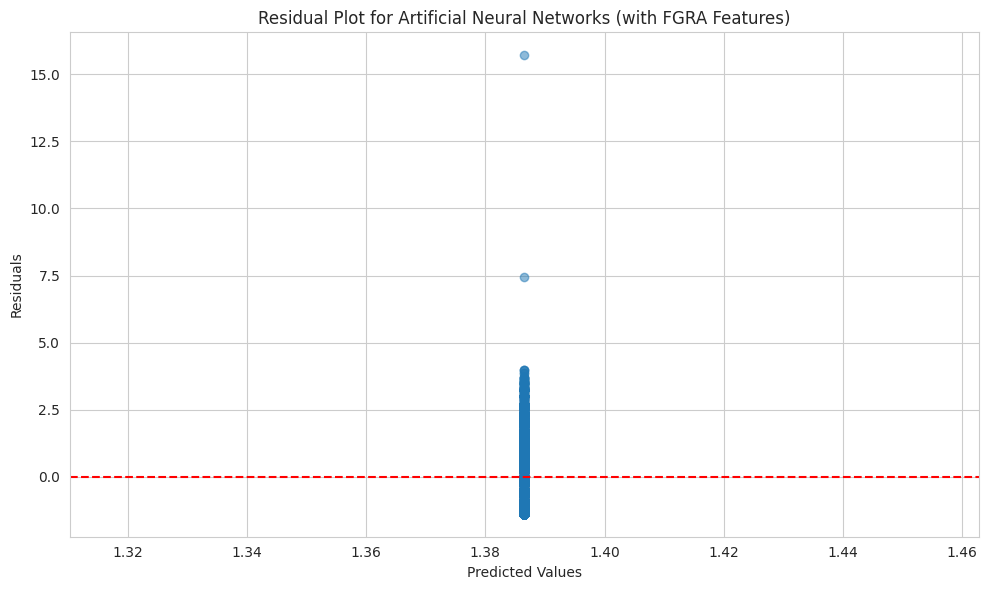

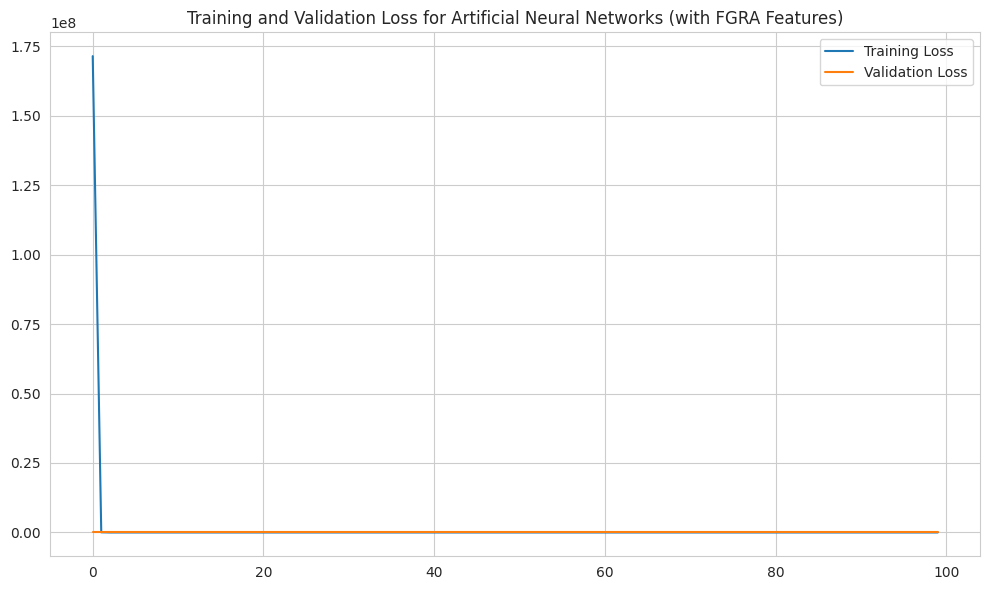

CPU times: user 1h 5min 56s, sys: 14min 31s, total: 1h 20min 27s
Wall time: 53min 56s


In [311]:
%%time
models_with_fgra = [
    ('Random Forest (with FGRA Features)', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting (with FGRA Features)', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('Artificial Neural Networks (with FGRA Features)', None),
]
predictions_with_fgra = train_and_evaluate_models(models_with_fgra, X_train_selected, y_train_selected, X_test_selected, y_test_selected)

# Model Optimization

## Optimized the best model

In [93]:
# optimize_model(model)

# Model Persistence

In [94]:
# Save model
# save_model(model, '../artifacts/models/optimized_model.joblib')